In [90]:
## Project 1B

In [91]:
# Initial imports
import os
import requests
from pathlib import Path
import json
import numpy as np
import datetime as dt
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [92]:
# Load .env enviroment variables
load_dotenv()

True

In [93]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    base_url="https://paper-api.alpaca.markets",
    api_version="v2")

In [94]:
# Format current date as ISO format
today = pd.Timestamp("2021-03-31", tz="America/New_York").isoformat()
start_day = pd.Timestamp("2016-03-31", tz="America/New_York").isoformat()
# need to update timeframe to 2016

# Set the tickers
tickers = ["SCHZ", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
ticker_data = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_day,
    end = today,
    limit = 1000
).df

# Preview DataFrame
ticker_data.head()

SCHZ                                        SPY  \
                            open     high     low   close    volume    open   
time                                                                          
2017-04-06 00:00:00-04:00  51.85  51.8500  51.750  51.840  256515.0     NaN   
2017-04-07 00:00:00-04:00  51.91  51.9200  51.680  51.765  302885.0     NaN   
2017-04-10 00:00:00-04:00  51.80  51.8400  51.760  51.810  459968.0     NaN   
2017-04-11 00:00:00-04:00  51.90  51.9653  51.847  51.940  407094.0  234.87   
2017-04-12 00:00:00-04:00  52.00  52.0800  51.950  52.050  443459.0  234.74   

                                                               
                             high     low   close      volume  
time                                                           
2017-04-06 00:00:00-04:00     NaN     NaN     NaN         NaN  
2017-04-07 00:00:00-04:00     NaN     NaN     NaN         NaN  
2017-04-10 00:00:00-04:00     NaN     NaN     NaN         NaN  
2017-04-11 00:00:00-04:00  235.18  233.34  235.04  63951745.0  
2017-04-12 00:00:00-04:00  234.96  233.77  234.10  55338215.0

In [97]:
#ticker_data.drop("open", "volume")
#ticker_data.head()

df_closingprice = pd.DataFrame()
df_closingprice["SCHZ"]= ticker_data["SCHZ"]["close"]
df_closingprice["SPY"]= ticker_data["SPY"]["close"]
df_closingprice.index=df_closingprice.index.date
df_closingprice.head()


,SCHZ,SPY
2017-04-06,51.840,NaN
2017-04-07,51.765,NaN
2017-04-10,51.810,NaN
2017-04-11,51.940,235.04
2017-04-12,52.050,234.10


In [98]:
df_closingprice.isnull().sum()

SCHZ    3
SPY     3
dtype: int64

In [99]:
df_closingprice = df_closingprice.dropna().copy()

In [100]:
df_closingprice.isnull().sum()

SCHZ    0
SPY     0
dtype: int64

In [101]:
df_closingprice.count()

SCHZ    997
SPY     997
dtype: int64

In [102]:
df_closingprice.head()

,SCHZ,SPY
2017-04-11,51.94,235.04
2017-04-12,52.05,234.10
2017-04-13,52.11,232.54
2017-04-17,52.11,234.57
2017-04-18,52.29,233.86


In [103]:
#Calculating initial traditional Income portfolio asset quantities
income_portfolio_amount = 100000
income_spy_percentage = 0.2
income_schz_percentage = 0.8
spy_close_price = df_closingprice["SPY"][0]
schz_close_price = df_closingprice["SCHZ"][0]
income_spy = income_portfolio_amount * income_spy_percentage / spy_close_price
income_schz = income_portfolio_amount * income_schz_percentage / schz_close_price
print(income_spy)
print(income_schz)

85.0918992511913
1540.2387370042356


In [104]:
income_portfolio_returns = df_closingprice.pct_change()
income_portfolio_returns = income_portfolio_returns.dropna().copy()
income_portfolio_returns.head()

,SCHZ,SPY
2017-04-12,0.002118,-0.003999
2017-04-13,0.001153,-0.006664
2017-04-17,0.000000,0.008730
2017-04-18,0.003454,-0.003027
2017-04-19,-0.001339,-0.001668


<AxesSubplot:title={'center':'Cumulative Returns'}>

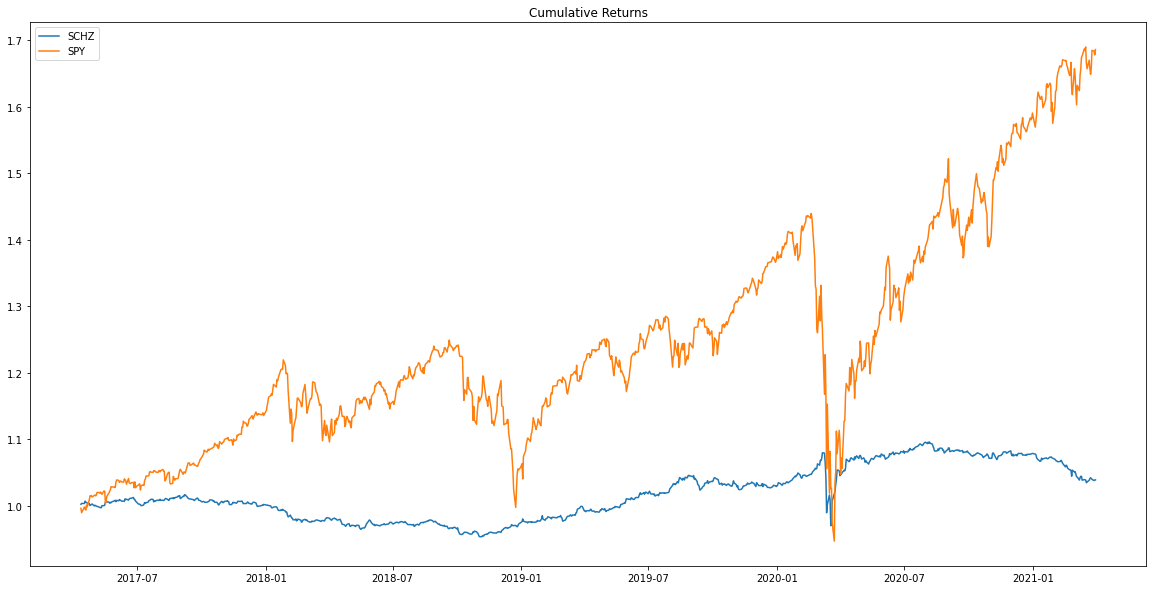

In [105]:
income_portfolio_cumulative_returns = (1 + income_portfolio_returns).cumprod()

#print(income_portfolio_cumulative_returns.shape)
#percent_pf = income_portfolio_cumulative_returns.dot([0.8],[0.2])
#print(percent_pf.shape)
income_portfolio_cumulative_returns.plot(figsize=(20,10), title = "Cumulative Returns")

In [106]:
#Combined Returns
income_portfolio_returns["Income Combined Returns"] = income_portfolio_returns["SCHZ"] * income_schz_percentage + income_portfolio_returns["SPY"]*income_spy_percentage
income_portfolio_returns.head()

,SCHZ,SPY,Income Combined Returns
2017-04-12,0.002118,-0.003999,0.000894
2017-04-13,0.001153,-0.006664,-0.000411
2017-04-17,0.000000,0.008730,0.001746
2017-04-18,0.003454,-0.003027,0.002158
2017-04-19,-0.001339,-0.001668,-0.001404


<AxesSubplot:title={'center':'Income Portfolio Cumulative Returns'}>

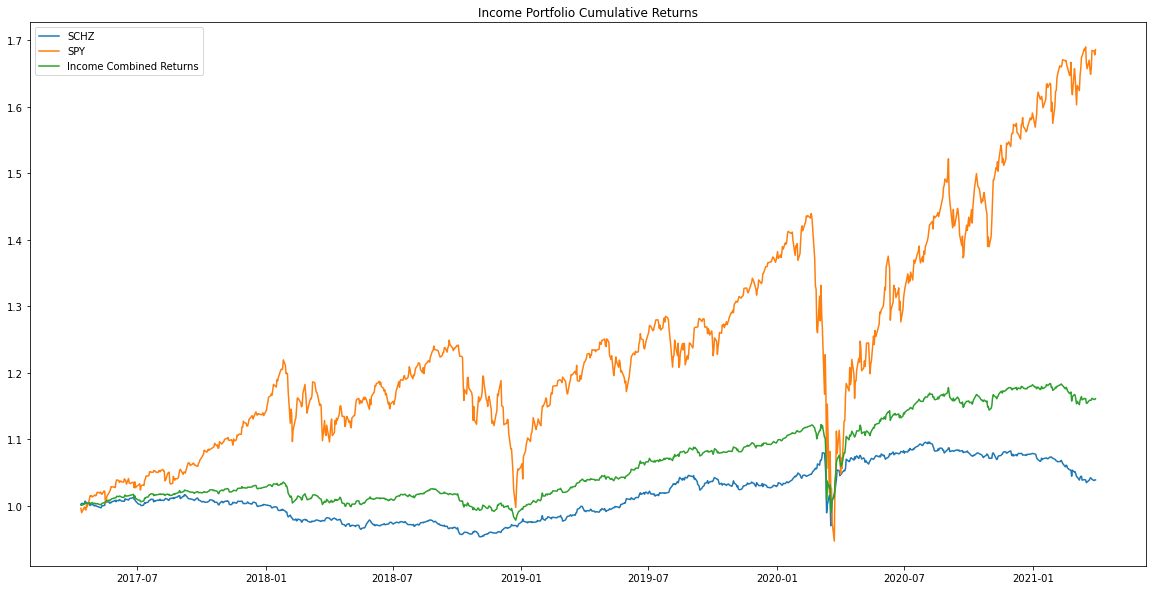

In [107]:
#show combined returns
income_portfolio_cumulative_returns = (1 + income_portfolio_returns).cumprod()
income_portfolio_cumulative_returns.plot(figsize=(20,10), title = "Income Portfolio Cumulative Returns")

In [126]:
btc_prices_csv = Path("resources/btc_usd_5_year_historical.csv")
btc_prices = pd.read_csv(
    btc_prices_csv, index_col="Date", infer_datetime_format=True, parse_dates=True)
btc_prices = btc_prices.sort_index()
btc_prices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-04-03,421.173004,421.579987,419.696991,420.903992,420.903992,38053700.0
2016-04-04,421.299011,422.342987,419.601013,421.444000,421.444000,50634300.0
2016-04-05,421.016998,424.256989,420.614014,424.029999,424.029999,60718000.0
2016-04-06,424.283997,424.527008,422.729004,423.412994,423.412994,59091000.0
2016-04-07,423.619995,423.657013,420.518005,422.744995,422.744995,57858600.0


In [127]:
btc_closingprice = pd.DataFrame()
btc_closingprice = btc_prices["Close"]
#btc_closingprice["BTC"]= ticker_data["BTC"]["close"]
btc_closingprice.index= btc_closingprice.index.date
btc_closingprice.head()

2016-04-03    420.903992
2016-04-04    421.444000
2016-04-05    424.029999
2016-04-06    423.412994
2016-04-07    422.744995
Name: Close, dtype: float64

In [128]:

df_closingprice.head()

,SCHZ,SPY
2017-04-11,51.94,235.04
2017-04-12,52.05,234.10
2017-04-13,52.11,232.54
2017-04-17,52.11,234.57
2017-04-18,52.29,233.86


In [129]:

income_crypto_portfolio = pd.concat([df_closingprice, btc_closingprice], axis="columns", join="inner")
income_crypto_portfolio= income_crypto_portfolio.rename(columns={"Close": "Crypto"})
income_crypto_portfolio.head()

,SCHZ,SPY,Crypto
2017-04-11,51.94,235.04,1205.010010
2017-04-12,52.05,234.10,1200.369995
2017-04-13,52.11,232.54,1169.280029
2017-04-17,52.11,234.57,1193.910034
2017-04-18,52.29,233.86,1211.670044


In [130]:
income_btc_percentage = 0.05
income_schz_percentage_2 = income_schz_percentage - (income_schz_percentage * income_btc_percentage)
income_spy_percentage_2 = income_spy_percentage - (income_spy_percentage * income_btc_percentage)
print(income_btc_percentage + income_schz_percentage_2 + income_spy_percentage_2)

1.0


In [131]:
income_crypto_returns = income_crypto_portfolio.pct_change()
income_crypto_returns = income_crypto_returns.dropna().copy()
income_crypto_returns.head()

,SCHZ,SPY,Crypto
2017-04-12,0.002118,-0.003999,-0.003851
2017-04-13,0.001153,-0.006664,-0.025900
2017-04-17,0.000000,0.008730,0.021064
2017-04-18,0.003454,-0.003027,0.014876
2017-04-19,-0.001339,-0.001668,-0.001139


In [132]:
#Combined Returns
income_crypto_returns["Income Combined Crypto Returns"] = income_crypto_returns["SCHZ"] * income_schz_percentage_2 + income_crypto_returns["SPY"] * income_spy_percentage_2 + income_crypto_returns["Crypto"] * income_btc_percentage 
income_crypto_returns.head()

,SCHZ,SPY,Crypto,Income Combined Crypto Returns
2017-04-12,0.002118,-0.003999,-0.003851,0.000657
2017-04-13,0.001153,-0.006664,-0.025900,-0.001685
2017-04-17,0.000000,0.008730,0.021064,0.002712
2017-04-18,0.003454,-0.003027,0.014876,0.002794
2017-04-19,-0.001339,-0.001668,-0.001139,-0.001391


<AxesSubplot:title={'center':'Income Portfolio Crypto Cumulative Returns'}>

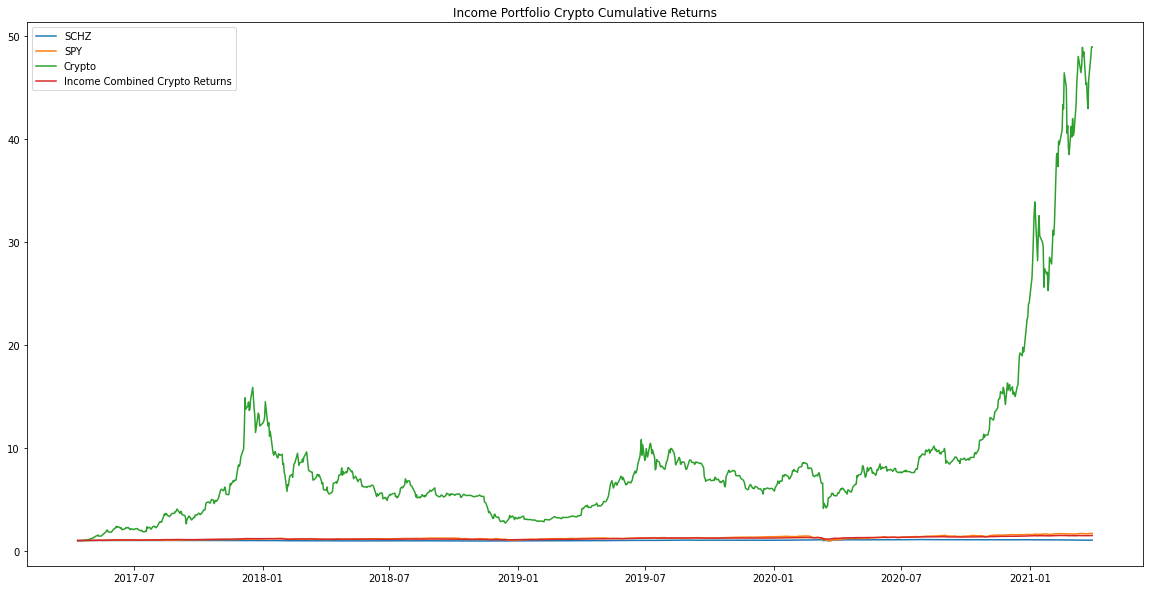

In [133]:
#show combined returns
income_cumulative_crypto_returns = (1 + income_crypto_returns).cumprod()
income_cumulative_crypto_returns.plot(figsize=(20,10), title = "Income Portfolio Crypto Cumulative Returns")

In [134]:
#Combined Returns
income_combined_traditional_returns = income_crypto_returns.drop(columns=["SCHZ","SPY","Crypto"])
income_combined_traditional_returns = 
income_combined_traditional_returns.head()

,Income Combined Crypto Returns
2017-04-12,0.000657
2017-04-13,-0.001685
2017-04-17,0.002712
2017-04-18,0.002794
2017-04-19,-0.001391


In [138]:
income_crypto_traditional_cumulative_returns = pd.concat([income_cumulative_crypto_returns, income_portfolio_cumulative_returns], axis="columns", join="inner")
income_crypto_traditional_cumulative_returns.head()

,SCHZ,SPY,Crypto,Income Combined Crypto Returns,SCHZ,SPY,Income Combined Returns
2017-04-12,1.002118,0.996001,0.996149,1.000657,1.002118,0.996001,1.000894
2017-04-13,1.003273,0.989364,0.970349,0.998971,1.003273,0.989364,1.000483
2017-04-17,1.003273,0.998000,0.990788,1.001680,1.003273,0.998000,1.002230
2017-04-18,1.006739,0.994980,1.005527,1.004479,1.006739,0.994980,1.004393
2017-04-19,1.005391,0.993320,1.004382,1.003081,1.005391,0.993320,1.002982


In [139]:
#Combined Returns
income_crypto_traditional_cumulative_returns = income_crypto_traditional_cumulative_returns.drop(columns=["SCHZ","SPY","Crypto"])
income_crypto_traditional_cumulative_returns.head()

,Income Combined Crypto Returns,Income Combined Returns
2017-04-12,1.000657,1.000894
2017-04-13,0.998971,1.000483
2017-04-17,1.001680,1.002230
2017-04-18,1.004479,1.004393
2017-04-19,1.003081,1.002982


<AxesSubplot:title={'center':'Income Portfolio Crypto Cumulative Returns'}>

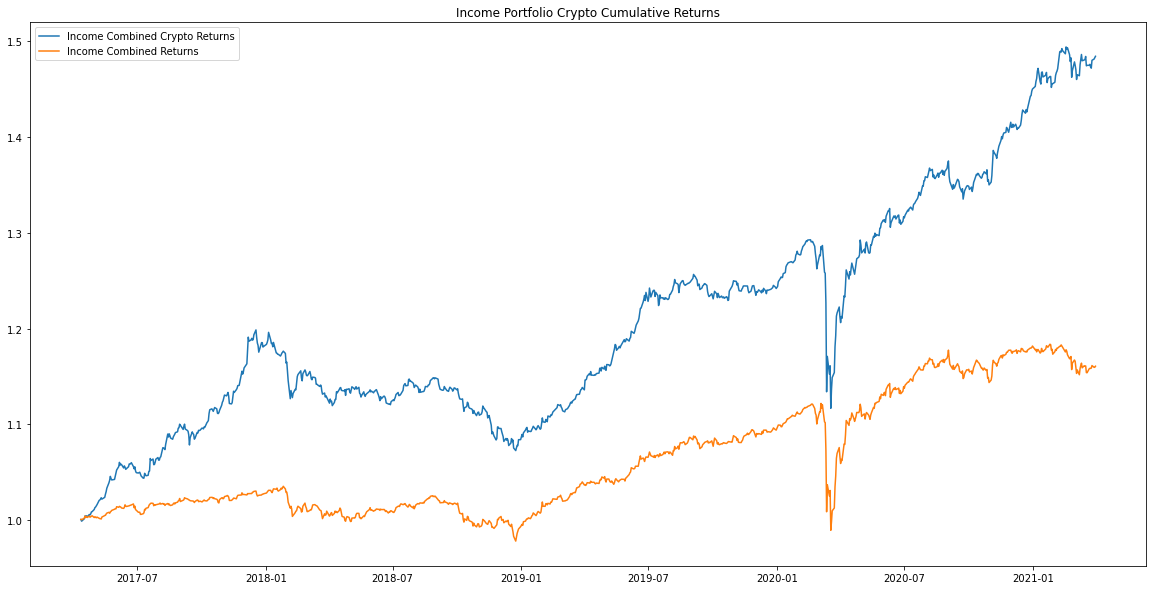

In [140]:
#show combined returns
income_crypto_traditional_cumulative_returns.plot(figsize=(20,10), title = "Income Portfolio Crypto Cumulative Returns")

In [146]:
income_crypto_traditional_cumulative_returns.std()

Income Combined Crypto Returns    0.118711
Income Combined Returns           0.060725
dtype: float64

In [147]:
income_crypto_traditional_cumulative_returns.mean()

Income Combined Crypto Returns    1.207623
Income Combined Returns           1.064513
dtype: float64

In [160]:
income_sharpe_ratios = income_crypto_traditional_cumulative_returns.mean() / income_crypto_traditional_cumulative_returns.std() * np.sqrt(1)
income_sharpe_ratios

Income Combined Crypto Returns    10.172760
Income Combined Returns           17.530092
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}>

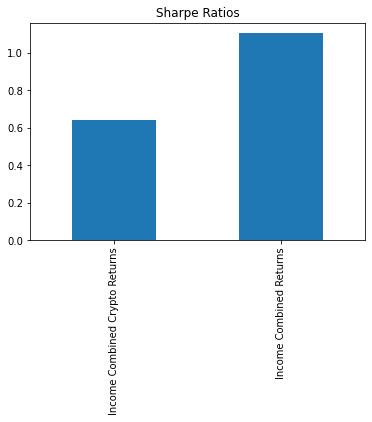

In [150]:
income_sharpe_ratios.plot(kind="bar", title="Sharpe Ratios")